In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.animation as animation
import matplotlib as mpl

In [2]:
# definition d'un objet element

class Node:
    id = 0
    def __init__(self, x, y, region):
        self.id = Node.id
        Node.id += 1
        self.x = x
        self.y = y
        self.region = region
        
    def __repr__(self):
        return f"Node {self.id} [{self.x},{self.y}], region = {self.region}"

class Element:
    id = 0
    def __init__(self, nodes):
        self.nodes = nodes
        self.id = Element.id
        Element.id += 1
        
    def getCoords(self):
        return np.array([[n.x,n.y] for n in self.nodes])
    
    def __repr__(self):
        return f"Element {self.id}\nNodes : {[n.id for n in self.nodes]}\nCoords : {self.getCoords()}"

def plotMesh(elements):
    
    fig, ax = plt.subplots()
    for e in elements:
        coords = e.getCoords()
        plt.fill(coords[:,0], coords[:,1], color="greenyellow", alpha=0.5, ec="k")
    ax.set_aspect("equal", "box")
    plt.show()

In [3]:
# definition du maillage

N = 20
L = 100.0
xCoords = np.linspace(0.0, L, N+1)
dof = (N+1)*(N+1)

omega = 1

Node.id = 0
nodesCoord = np.array([[[x,y] for x in xCoords] for y in xCoords]).reshape((dof,2))
nodes = [Node(coord[0], coord[1], omega) for coord in nodesCoord]

Element.id = 0
elements = []
for i in range(N*N):
    nodesIdx = [i+i//N,i+1+i//N,i+N+2+i//N,i+N+1+i//N]
    elements.append(Element([nodes[n] for n in nodesIdx]))

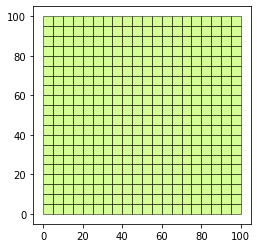

In [4]:
plotMesh(elements)

In [5]:
# définition des interpolateurs (P1 : linéaire) et de ses dérivées partielles
phi = [
    lambda u,v : 0.25*(1-u)*(1-v), # (-1,-1)
    lambda u,v : 0.25*(1+u)*(1-v), # (+1,-1)
    lambda u,v : 0.25*(1+u)*(1+v), # (+1,+1)
    lambda u,v : 0.25*(1-u)*(1+v), # (-1,+1)
]

duphi = [
        lambda u,v : -0.25*(1-v),   # (-1,-1)
        lambda u,v : 0.25*(1-v),    # (+1,-1)
        lambda u,v : 0.25*(1+v),   # (-1,+1)
        lambda u,v : -0.25*(1+v),   # (+1,+1)
]
dvphi = [
        lambda u,v : -0.25*(1-u),   # (-1,-1)
        lambda u,v : -0.25*(1+u),   # (+1,-1)
        lambda u,v : 0.25*(1+u),    # (-1,+1)
        lambda u,v : 0.25*(1-u),    # (+1,+1)
]

gradPhi = [
        lambda u,v: np.array([duphi[i](u,v), dvphi[i](u,v)])
        for i in range(4)
]

# fonction retournant l'interpolateur selon les 4 fonctions phi pour les 4 valeurs aux noeuds X
def interp(phiList, X):
    return lambda u,v : sum([phi(u,v)*x for phi,x in zip(phiList, X)])

In [6]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne

for e in elements:

    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    e.detJ = lambda u,v : dxdu(u,v)*dydv(u,v) - dxdv(u,v)*dydu(u,v)

    e.iJ = lambda u,v :  np.array(
        [[dydv(u,v), -dydu(u,v)],
        [-dxdv(u,v), dxdu(u,v)]]
    )/e.detJ(u,v)

In [7]:
# Détermination d'une règle de quadrature 

# nombre de points de quadrature (par dimension)
Nquad = 5 

# importation poids et abscices Gauss-Legendre
data = np.loadtxt(f"../quadratureRules/gl_{Nquad:02d}.tab")
w_i, xi_i = data[:,0], data[:,1] 

# Compute the 2D integral of f(u,v) over [-1,1]x[-1,1]

int2D = lambda f: sum([ sum([w1*w2 * f(xi1, xi2) for xi1,w1 in zip(xi_i, w_i)]) for xi2,w2 in zip(xi_i, w_i)])

In [8]:
# Calcul des matrices élémentaires locales -> à optimiser

for e in tqdm(elements):

    e.Ke = np.zeros((4,4))
    e.Me = np.zeros((4,4))
    
    for i in range(4):
        for j in range(4):

            fk = lambda u,v: (e.iJ(u,v)@gradPhi[i](u,v))@(e.iJ(u,v)@gradPhi[j](u,v))*e.detJ(u,v)
            e.Ke[i,j] = int2D(fk)

            fm = lambda u,v: phi[i](u,v)*phi[j](u,v)*e.detJ(u,v)
            e.Me[i,j] = int2D(fm)

100%|██████████| 400/400 [00:11<00:00, 33.42it/s]


In [9]:
# Calcule des matrices globales -> à optimiser
K = np.zeros((dof,dof))
M = np.zeros((dof,dof))
F = np.zeros(dof)

for e in elements:
    for (i,n1) in enumerate(e.nodes):
        for (j,n2) in enumerate(e.nodes):
            K[n1.id,n2.id] += e.Ke[i,j]
            M[n1.id,n2.id] += e.Me[i,j]

In [10]:
# Conditions aux limites : point source (CL sur le déplacement)

noeudSource = int(dof/2)

K[noeudSource,:] = 0
K[noeudSource,noeudSource] = 1

In [23]:
# inverting mass matrix

iM = np.linalg.inv(M)

In [34]:
# résolution temporelle

Nit = 200
cfl = 0.5
Δt = L/N* cfl
T = Δt*Nit 

time = np.linspace(0,T,Nit)

U = np.zeros((Nit, dof))

# définition source

t0 = T/10.0         # tuning
f0 = T*0.1/500      # tuning
f = lambda t : (4*(t-t0)**2*f0**4 - 2*f0**2)*np.exp(-(t-t0)**2*f0**2)

(200, 441)
(441,)


In [36]:
for i in tqdm(range(2,Nit)):
    F[noeudSource] = f(i*Δt)
    U[i,:] = 2.0*U[i-1,:] - U[i-2,:] + Δt**2 * (iM@(F-K@U[i-1,:]))

100%|██████████| 198/198 [00:00<00:00, 6818.27it/s]


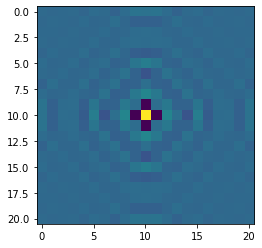

In [40]:
idx = 30
plt.imshow(U[idx,:].reshape((N+1,N+1)))